Добавить <br>
1.  Указатели портфелей, которые рассчитаны по Келли и МВ +++
2.  Симуляция от дневных доходностей и дисперсии +++
3.  Количество тикеров в функции с симуляцией +++


In [2]:
from data_wrangle import data_wrangle as dw


import numpy as np
import pandas as pd
import yfinance as yf 
import matplotlib.pyplot as plt
import pypfopt

from cvxopt import matrix
from cvxopt.solvers import qp
from sklearn.covariance import LedoitWolf
from pypfopt import risk_models, expected_returns, plotting, EfficientFrontier

In [3]:
# Define function to calculate returns, volatility
def portfolio_annualized_performance(weights, mean_returns, cov_matrix, input_annual=False):
    # Given the avg returns, weights of equities calc. the portfolio return
    if input_annual:
        returns = np.sum(mean_returns*weights)
    else:
        returns = np.sum(mean_returns*weights) *252
    # Standard deviation of portfolio (using dot product against covariance, weights)
    # 252 trading days
    if input_annual:
        std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    else:
        std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [4]:
def generate_random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    # Initialize array of shape 3 x N to store our results, 
    # where N is the number of portfolios we're going to simulate
    results = np.zeros((3,num_portfolios))
    # Array to store the weights of each equity
    weight_array = []
    for i in range(num_portfolios):
        # Randomly assign floats to our 4 equities
        weights = np.random.random(len(cov_matrix))
        # Convert the randomized floats to percentages (summing to 100)
        weights /= np.sum(weights)
        # Add to our portfolio weight array
        weight_array.append(weights)
        # Pull the standard deviation, returns from our function above using 
        # the weights, mean returns generated in this function
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        # Store output
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        # Sharpe ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weight_array

In [5]:
def kelly_optimize(M_df:pd.DataFrame, C_df:pd.DataFrame, risk_free_rate)->pd.DataFrame:
    "objective function to maximize is: g(F) = r + F^T(M-R) - F^TCF/2"
    r = risk_free_rate
    M = M_df.to_numpy()
    C = C_df.to_numpy()

    n = M.shape[0]
    A = matrix(1.0, (1, n))
    b = matrix(1.0)
    G = matrix(0.0, (n, n))
    G[::n+1] = -1.0
    h = matrix(0.0, (n, 1))
    try:
        max_pos_size = float(0.99)
    except KeyError:
        max_pos_size = None
    try:
        min_pos_size = float(0)
    except KeyError:
        min_pos_size = None
    if min_pos_size is not None:
        h = matrix(min_pos_size, (n, 1))

    if max_pos_size is not None:
       h_max = matrix(max_pos_size, (n,1))
       G_max = matrix(0.0, (n, n))
       G_max[::n+1] = 1.0
       G = matrix(np.vstack((G, G_max)))
       h = matrix(np.vstack((h, h_max)))

    S = matrix((1.0 / ((1 + r) ** 2)) * C)
    q = matrix((1.0 / (1 + r)) * (M - r))
    sol = qp(S, -q, G, h, A, b)
    kelly = np.array([sol['x'][i] for i in range(n)])
    kelly = pd.DataFrame(kelly, index=C_df.columns, columns=['Weights'])
    return kelly

In [22]:
def display_simulated_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate):

    # pull results, weights from random portfolios
    results, weights = generate_random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

    # pull the max portfolio Sharpe ratio (3rd element in results array from 
    # generate_random_portfolios function)
    max_sharpe_idx = np.argmax(results[2])

    # pull the associated standard deviation, annualized return w/ the max Sharpe ratio
    stdev_portfolio, returns_portfolio = results[0,max_sharpe_idx], results[1,max_sharpe_idx]

    # pull the allocation associated with max Sharpe ratio
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=cov_matrix.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    print("-"*100)
    print("Portfolio at maximum Sharpe Ratio\n")
    print("--Returns, volatility--\n")
    print("Annualized Return:", round(returns_portfolio,2))
    print("Annualized Volatility:", round(stdev_portfolio,2))

    print("\n")
    print("--Allocation at max Sharpe ratio--\n")
    print(max_sharpe_allocation)
    print("-"*100)

    plt.figure(figsize=(16, 9))
    # x = volatility, y = annualized return, color mapping = sharpe ratio
    plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap='winter', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    # Mark the portfolio w/ max Sharpe ratio
    plt.scatter(stdev_portfolio, returns_portfolio, marker='x',color='r',s=150, label='Max Sharpe ratio')
    plt.title('Simulated portfolios illustrating efficient frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=1.2)
    return stdev_portfolio, returns_portfolio, max_sharpe_allocation


In [7]:
inst = dw()
start = '2000-01-01'
end = '2020-12-31'

In [8]:
tickers = ["MSFT", "AMZN", 'PFE', 'DIS']
ohlc = yf.download(tickers, start=start, end=end)
prices = ohlc['Adj Close'].dropna(how="all")
risk_free_rate = 0.02
num_portfolios = 10000

# without risk-free annual
returns_wf = expected_returns.mean_historical_return(prices, compounding=True)
cov_matrix_prep = risk_models.sample_cov(prices)

# with risk-free annual
returns_prep = expected_returns.mean_historical_return(prices, compounding=True)
cov_matrix, returns = inst.add_risk_free(cov_matrix_prep, returns=returns_prep, risk_free=risk_free_rate)

# without risk-free daily
daily_returns = expected_returns.mean_historical_return(prices, compounding=True, frequency=1)
cov_matrix_daily = risk_models.sample_cov(prices, frequency=1)

# with risk-free daily
daily_returns_prep = expected_returns.mean_historical_return(prices, compounding=True, frequency=1)
cov_matrix_d, returns_d = inst.add_risk_free(cov_matrix_daily, returns=daily_returns_prep, risk_free=risk_free_rate / 252)


[*********************100%***********************]  4 of 4 completed


### Daily returns and covariance

In [9]:
ef = EfficientFrontier(daily_returns, cov_matrix_daily)  # weight_bounds automatically set to (0, 1)
ef.max_sharpe(risk_free_rate=risk_free_rate / 252)
weights = ef.clean_weights()
kelly = kelly_optimize(daily_returns, cov_matrix_daily, risk_free_rate / 252)


     pcost       dcost       gap    pres   dres
 0: -1.9049e-04 -4.4504e+00  4e+00  2e-16  5e-16
 1: -1.9050e-04 -4.5002e-02  4e-02  2e-16  7e-16
 2: -1.9135e-04 -9.4015e-04  7e-04  1e-16  1e-17
 3: -2.1297e-04 -2.8169e-04  7e-05  2e-16  8e-19
 4: -2.2565e-04 -2.3168e-04  6e-06  8e-17  5e-20
 5: -2.2733e-04 -2.2756e-04  2e-07  1e-16  4e-20
 6: -2.2746e-04 -2.2746e-04  2e-09  2e-16  2e-20
Optimal solution found.


### Annualized returns and covariance

In [10]:
ef_wf = EfficientFrontier(returns_wf, cov_matrix_prep)  # weight_bounds automatically set to (0, 1)
ef_wf.max_sharpe(risk_free_rate=risk_free_rate)
weights_wf = ef_wf.clean_weights()
kelly_wf = kelly_optimize(returns_wf, cov_matrix_prep, risk_free_rate)

     pcost       dcost       gap    pres   dres
 0: -5.5269e-02 -4.5695e+00  5e+00  2e-16  4e-16
 1: -5.5961e-02 -1.8350e-01  1e-01  2e-16  3e-16
 2: -6.3699e-02 -7.5641e-02  1e-02  1e-16  3e-17
 3: -6.6465e-02 -6.7473e-02  1e-03  2e-16  1e-17
 4: -6.6768e-02 -6.6815e-02  5e-05  2e-16  7e-18
 5: -6.6780e-02 -6.6781e-02  8e-07  2e-16  2e-17
 6: -6.6781e-02 -6.6781e-02  8e-09  1e-16  8e-18
Optimal solution found.


In [11]:
print(kelly.round(4))
weights

      Weights
AMZN   0.4268
DIS    0.4667
MSFT   0.1065
PFE    0.0000


OrderedDict([('AMZN', 0.39483),
             ('DIS', 0.4683),
             ('MSFT', 0.13687),
             ('PFE', 0.0)])

In [12]:
print(kelly_wf.round(4))
weights_wf

      Weights
AMZN   0.4889
DIS    0.4581
MSFT   0.0530
PFE    0.0000


OrderedDict([('AMZN', 0.41961),
             ('DIS', 0.46239),
             ('MSFT', 0.118),
             ('PFE', 0.0)])

## Statistics for Kelly - from daily

In [13]:
kelly_weight_format = np.array(kelly).reshape(len(kelly))
kelly_port_std, kelly_port_ret = portfolio_annualized_performance(weights=kelly_weight_format, 
                                                                  mean_returns=daily_returns, 
                                                                  cov_matrix=cov_matrix_daily, 
                                                                  input_annual=False)


In [14]:
kelly_port_std

0.31948602803159154

In [15]:
kelly_port_ret

0.12835634964460294

In [16]:
kelly_weight_format_ann = np.array(kelly_wf).reshape(len(kelly_wf))
kelly_port_std_ann, kelly_port_ret_ann = portfolio_annualized_performance(weights=kelly_weight_format_ann, 
                                                                  mean_returns=returns_wf, 
                                                                  cov_matrix=cov_matrix_prep, 
                                                                  input_annual=True)

In [17]:
kelly_port_std_ann

0.33685863714090974

In [18]:
kelly_port_ret_ann

0.1437404959525053

----------------------------------------------------------------------------------------------------
Portfolio at maximum Sharpe Ratio

--Returns, volatility--

Annualized Return: 0.11
Annualized Volatility: 0.28


--Allocation at max Sharpe ratio--

             AMZN    DIS   MSFT   PFE
allocation  30.54  43.74  18.11  7.61
----------------------------------------------------------------------------------------------------


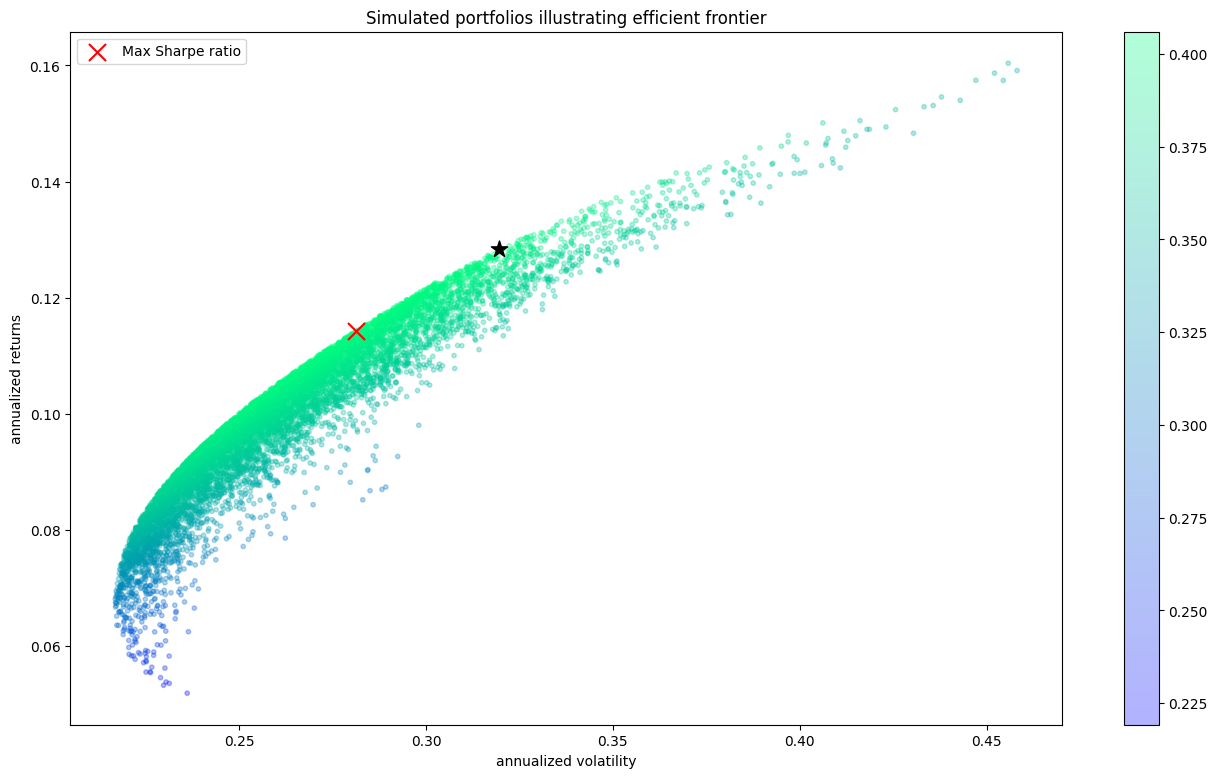

In [23]:
sd, ret, max_sharpe = display_simulated_portfolios(mean_returns=daily_returns, 
                             cov_matrix=cov_matrix_daily, 
                             num_portfolios=num_portfolios, 
                             risk_free_rate=risk_free_rate / 252)
plt.scatter(kelly_port_std, kelly_port_ret, marker='*',color='black',s=150, label='KellyDaily')


In [21]:
kelly

,Weights
AMZN,0.426785
DIS,0.466706
MSFT,0.106475
PFE,0.000034


In [24]:
max_sharpe

,AMZN,DIS,MSFT,PFE
allocation,30.54,43.74,18.11,7.61
